In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

(768, 1024)


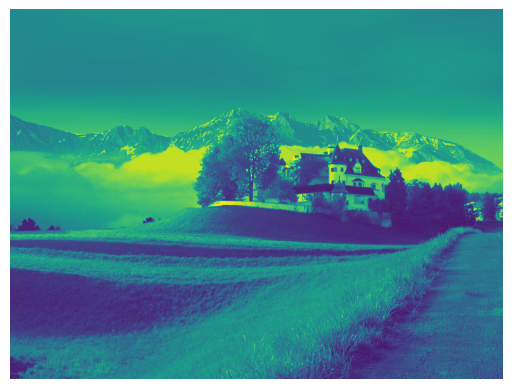

In [2]:
I = cv2.imread("sample4.jpg", 0)
# I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
# I = 0.29 * I[..., 0] + 0.58 * I[..., 1] + 0.11 * I[..., 2] 
plt.imshow(I);plt.axis("off")
print(I.shape)

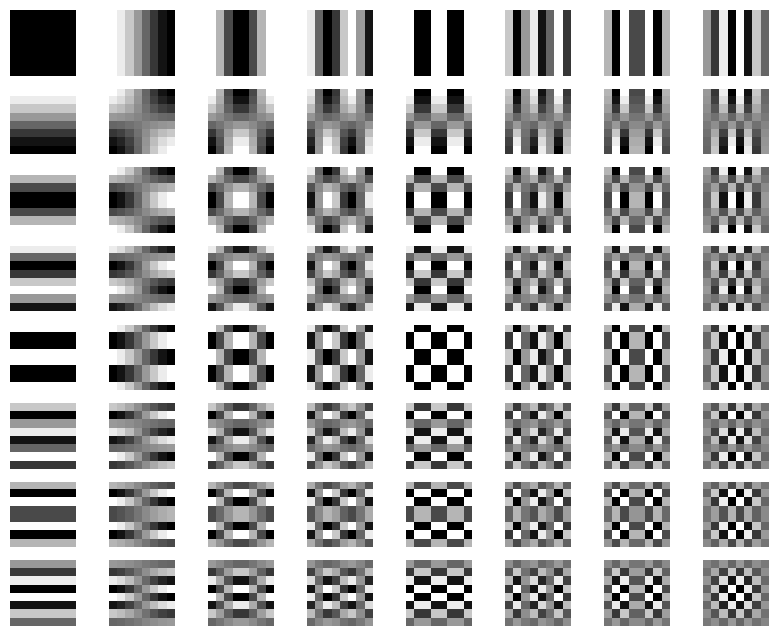

In [3]:
coef_base = np.zeros((8, 8, 8, 8))
for u in range(8):
    for v in range(8):
        for x in range(8):
            for y in range(8):
                coef_base[u, v, x, y] = np.cos(((2 * x + 1) * u * np.pi) / 16) * np.cos(((2 * y + 1) * v * np.pi) / 16)
fig, axes = plt.subplots(8, 8, figsize=(10, 8))
for u in range(8):
    for v in range(8):
        axes[u, v].imshow(coef_base[u, v], cmap="gray")
        axes[u, v].axis("off")
plt.show()

In [4]:
I[...]

array([[121, 121, 121, ..., 116, 116, 116],
       [121, 121, 121, ..., 117, 117, 117],
       [121, 121, 121, ..., 117, 117, 117],
       ...,
       [ 22,  26,  25, ...,  63,  67,  41],
       [ 16,  19,  19, ...,  56,  72,  60],
       [ 22,  21,  18, ...,  59,  34,  79]], dtype=uint8)

In [5]:
def QQC(degree):
    newQ = np.zeros((8, 8), dtype=np.uint8)
    if 1 < degree < 50:
        for i in range(8):
            for j in range(8):
                newQ[i, j] = np.clip((50 / degree) * Q[i, j], 0, 255)
        return newQ
    elif 50 < degree < 100:
        for i in range(8):
            for j in range(8):
                newQ[i, j] = np.clip(((100 - degree) / 50) * Q[i, j], 0, 255)
        return newQ
    elif degree == 50:
        return Q
    else:
        return "sorry but not possible"


Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
              [12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]])
QQC(90)
QQC(50)
QQC(10)

array([[ 80,  55,  50,  80, 120, 200, 255, 255],
       [ 60,  60,  70,  95, 130, 255, 255, 255],
       [ 70,  65,  80, 120, 200, 255, 255, 255],
       [ 70,  85, 110, 145, 255, 255, 255, 255],
       [ 90, 110, 185, 255, 255, 255, 255, 255],
       [120, 175, 255, 255, 255, 255, 255, 255],
       [245, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255]], dtype=uint8)

In [6]:
num_blocks = (I.shape[0] // 8, I.shape[1] // 8)
blocks = np.empty((num_blocks[0], num_blocks[1], 8, 8))
for i, k in zip(range(0, num_blocks[0]), range(0, I.shape[0], 8)):
    for j, l in zip(range(0, num_blocks[1]), range(0, I.shape[1], 8)):
        blocks[i, j] = I[k:k + 8, l:l + 8]
width, height, _, _ = blocks.shape

In [7]:
blocks[95, 127]

array([[ 71., 118.,  92.,  64.,  47.,  73.,  61.,  36.],
       [ 50., 185., 110.,  69.,  26.,  85.,  90.,  64.],
       [ 64., 113.,  87.,  43.,  61.,  77.,  93.,  72.],
       [ 80.,  88.,  68.,  62.,  67., 113.,  75.,  46.],
       [128.,  99.,  62.,  55.,  94.,  66.,  64.,  39.],
       [ 84.,  96.,  65.,  60.,  54.,  63.,  67.,  41.],
       [ 36.,  51., 120.,  61.,  76.,  56.,  72.,  60.],
       [ 66.,  65.,  93.,  54.,  72.,  59.,  34.,  79.]])

In [8]:
def DCT(arr):
    width, height, _, _ = arr.shape
    result = np.zeros_like(arr)
    g_x = arr - 128
    for row in range(width):
        for column in range(height):
            for u in range(8):
                au = 1
                if u == 0: au = (1 / np.sqrt(2))
                for v in range(8):
                    sumGx = 0
                    av = 1
                    if v == 0: av = (1 / np.sqrt(2))
                    for x in range(8):
                        for y in range(8):
                            sumGx = sumGx + g_x[row, column, x, y] * np.cos(((2 * x + 1) * u * np.pi) / 16) * np.cos(
                                ((2 * y + 1) * v * np.pi) / 16)
                    result[row, column, u, v] = (1 / 4) * au * av * sumGx
    return result

dct = DCT(blocks)

In [114]:
def quantizition(arr, Q):
    quant = QQC(Q)
    finalStep = np.zeros_like(arr)
    for i in range(width):
        for j in range(height):
            for x in range(8):
                for y in range(8):
                    finalStep[i, j, x, y] = round(arr[i, j, x, y] / quant[x, y])
    return finalStep

qun = quantizition(dct, 50)

In [115]:
qun[70, 30]

array([[-17.,  -3.,   2.,  -2.,   1.,   0.,   0.,   0.],
       [  3.,   3.,  -2.,   0.,   0.,   0.,   0.,   0.],
       [  4.,   0.,  -1.,   0.,   0.,   1.,   0.,   0.],
       [  5.,  -3.,  -1.,   0.,   0.,   0.,   0.,   0.],
       [  0.,  -1.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ -1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

In [109]:
def energy_left(arr, energy):
    now = np.zeros_like(arr)
    leftEnergy = round(8*energy/100)
    for i in range(width):
        for j in range(height):
            now[i, j, leftEnergy:] = arr[i, j, leftEnergy:]
            now[i, j, :, leftEnergy:] = arr[i, j, :, leftEnergy:]
    return arr
newImg_70 = energy_left(qun, 70)

In [112]:
newImg_50 = energy_left(qun, 50)
newImg_30 = energy_left(qun, 30)

In [107]:
def energy_left(arr, energy):
    leftEnergy = round(8 * energy / 100)
    width, height = arr.shape[:2]  
    for i in range(width):
        for j in range(height):
            arr[i, j, leftEnergy:] = 0
            arr[i, j, :, leftEnergy:] = 0
    return arr
newImg_70 = energy_left(qun, 70)
newImg_50 = energy_left(qun, 50)
newImg_30 = energy_left(qun, 30)


In [113]:
newImg_30[70, 30]

array([[-17.,  -3.,   2.,  -2.,   1.,   0.,   0.,   0.],
       [  3.,   3.,  -2.,   0.,   0.,   0.,   0.,   0.],
       [  4.,   0.,  -1.,   0.,   0.,   1.,   0.,   0.],
       [  5.,  -3.,  -1.,   0.,   0.,   0.,   0.,   0.],
       [  0.,  -1.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ -1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

In [116]:
def inv_DCT(arr):
    width, height, _, _ = arr.shape
    result = np.zeros_like(arr)
    g_x = arr
    for row in range(width):
        for column in range(height):
            for u in range(8):
                au = 1 / np.sqrt(8)
                if u == 0: au = (1 / 2)
                for v in range(8):
                    sumGx = 0
                    av = 1 / np.sqrt(8)
                    if v == 0: av = (1 / 2)
                    for x in range(8):
                        for y in range(8):
                            sumGx = sumGx + g_x[row, column, x, y] * np.cos(((2 * x + 1) * u * np.pi) / 16) * np.cos(
                                ((2 * y + 1) * v * np.pi) / 16)
                    result[row, column, u, v] = (1 / 4) * au * av * sumGx
    result += 128
    return result

In [117]:
inv_dct_30 = inv_DCT(np.array(newImg_30))
inv_dct_50 = inv_DCT(np.array(newImg_50))
inv_dct_70 = inv_DCT(np.array(newImg_70))

In [76]:
new_Img = np.empty((I.shape[0], I.shape[1]), dtype = np.uint8)
for i, k in zip(range(0, num_blocks[0]), range(0, I.shape[0], 8)):
    for j, l in zip(range(0, num_blocks[1]), range(0, I.shape[1], 8)):
        new_Img[k:k + 8, l:l + 8] = inv_dct_70[i, j]


In [118]:
def restord(img):
    new_Img = np.empty((I.shape[0], I.shape[1]), dtype = np.uint8)
    for i, k in zip(range(0, num_blocks[0]), range(0, I.shape[0], 8)):
        for j, l in zip(range(0, num_blocks[1]), range(0, I.shape[1], 8)):
            new_Img[k:k + 8, l:l + 8] = img[i, j]
    return new_Img

In [124]:
new_Img_30 = restord(inv_dct_30)
new_Img_50 = restord(inv_dct_50)
new_Img_70 = restord(inv_dct_70)

Text(0.5, 1.0, 'reconstructed image by energy = 70%')

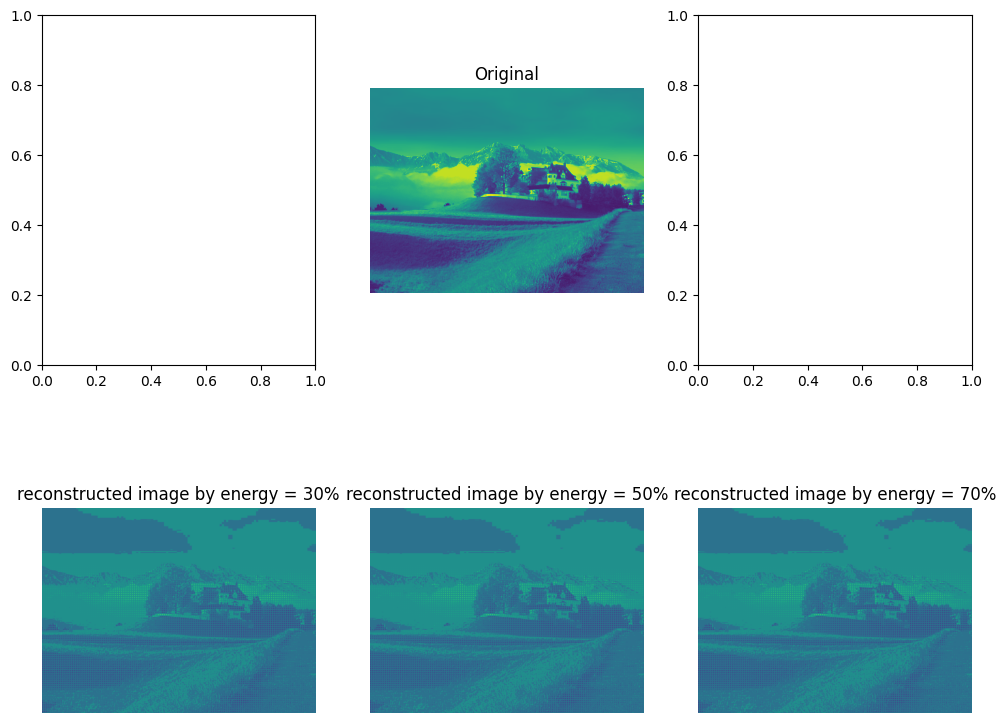

In [125]:
# fig , axe = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
fig , axe = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
axe[0, 1].imshow(I);axe[0, 1].axis("off");axe[0, 1].set_title("Original")
axe[1, 0].imshow(new_Img_30);axe[1, 0].axis("off");axe[1, 0].set_title("reconstructed image by energy = 30%")
axe[1, 1].imshow(new_Img_30);axe[1, 1].axis("off");axe[1, 1].set_title("reconstructed image by energy = 50%")
axe[1, 2].imshow(new_Img_30);axe[1, 2].axis("off");axe[1, 2].set_title("reconstructed image by energy = 70%")

In [ ]:
def zigzag(mat):
    index_order = sorted(((x, y) for x in range(8) for y in range(8)),
                         key=lambda x: (x[0] + x[1], -x[1] if (x[0] + x[1]) % 2 else x[1]))
    order_array = np.zeros((width, height, 64))
    for u in range(width):
        for v in range(height):
            order_array[u, v] = [mat[u, v, i, j] for i, j in index_order]
    return order_array

orderArray = zigzag(qun)